# Jupyter notebook for plotting Figure 3 and supplementary Appendix E figures in "Conformal Validity Guarnatees Exist for Any Data Distribution" (ICML 2024)

Notebook by Drew Prinster (drew@cs.jhu.edu)

Last updated June 28th, 2024

In [31]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.gridspec import GridSpec

from sklearn.kernel_ridge import KernelRidge
from sklearn import decomposition
from scipy.stats import logistic


In [33]:
from scipy.io import arff
import pandas as pd
import numpy as np

# Load the ARFF file
# The loadarff function returns a tuple: (data as a record array, metadata)
robot_arm_data_, meta_ = arff.loadarff(os.getcwd().removesuffix('bash_scripts') + '/datasets/robot_arm/dataset_2175_kin8nm.arff')
robot_arm_data = pd.DataFrame(robot_arm_data_)
X_robot_arm = robot_arm_data.iloc[:, :-1].to_numpy()
Y_robot_arm = robot_arm_data.iloc[:, -1].to_numpy()
n_robot_arm = len(robot_arm_data)
# Convert the record array into a pandas DataFrame
n_robot_arm

8192

In [34]:
dataset = 'robot_arm'
pc_alpha = 0.2
heteroscedastic = 'N'
noise_magnitude=0.05
seed=2
n_val = 100
n_initial_all = 200
replacement=True
n_train_proper_initial = 100
initial_sampling_bias = 8.0

print(f"pc_alpha : {pc_alpha}")

def compute_errors_for_measurements(X_vals, Y_vals):
    """
    Given indices of sequences, return noisy measurements (using estimated measurement noise SD).

    :param Y_vals: Y values
    :param muh: predictor function whose predictions are used for estimating measurement noise magnitude
    :param seed: int, random seed
    :return: numpy array of noisy measurements corresponding to provided sequence indices
    """

    krr = KernelRidge(alpha=1.0)
    krr.fit(X_vals, Y_vals)
    return abs(Y_vals - krr.predict(X_vals))

if (dataset == 'airfoil'):
    airfoil = pd.read_csv(os.getcwd().removesuffix('bash_scripts') + '/datasets/airfoil/airfoil.txt', sep = '\t', header=None)
    airfoil.columns = ["Frequency","Angle","Chord","Velocity","Suction","Sound"]
    X_airfoil = airfoil.iloc[:, 0:5].values
    X_airfoil[:, 0] = np.log(X_airfoil[:, 0])
    X_airfoil[:, 4] = np.log(X_airfoil[:, 4])
    Y_airfoil = airfoil.iloc[:, 5].values
    n_airfoil = len(Y_airfoil)
    # errs_airfoil = compute_errors_for_measurements(X_airfoil, Y_airfoil)


elif (dataset == 'wine'):
    winequality_red = pd.read_csv(os.getcwd().removesuffix('bash_scripts') + '/datasets/wine/winequality-red.csv', sep=';')
    X_wine = winequality_red.iloc[:, 0:11].values
    Y_wine = winequality_red.iloc[:, 11].values
    n_wine = len(Y_wine)
    # errs_wine = compute_errors_for_measurements(X_wine, Y_wine)

    print("X_wine shape : ", X_wine.shape)


elif (dataset == 'communities'):
    # UCI Communities and Crime Data Set
    # download from:
    # http://archive.ics.uci.edu/ml/datasets/communities+and+crime
    communities_data = np.loadtxt(os.getcwd().removesuffix('bash_scripts') + '/datasets/communities/communities.data',delimiter=',',dtype=str)
    # remove categorical predictors
    communities_data = np.delete(communities_data,np.arange(5),1)
    # remove predictors with missing values
    communities_data = np.delete(communities_data,\
                np.argwhere((communities_data=='?').sum(0)>0).reshape(-1),1)
    communities_data = communities_data.astype(float)
    X_communities = communities_data[:,:-1] ## Reducing size for 20250627
    Y_communities = communities_data[:,-1] ## Reducing size for 20250627
    n_communities = len(Y_communities)
    # errs_communities = compute_errors_for_measurements(X_communities, Y_communities)
    print("X_communities shape : ", X_communities.shape)

elif (dataset == 'meps'):
    meps_data = np.loadtxt(os.getcwd().removesuffix('bash_scripts') + '/datasets/meps/meps_data.txt')
    X_meps = meps_data[:,:-1] 
    Y_meps = meps_data[:,-1]
    n_meps = len(Y_meps)
    # errs_meps = compute_errors_for_measurements(X_meps, Y_meps)
    print("X_meps shape : ", X_meps.shape)

elif (dataset == 'blog'):
    blog_data = np.loadtxt(os.getcwd().removesuffix('bash_scripts') + '/datasets/blog/blogData_train.csv',delimiter=',')
    X_blog = blog_data[:,:-1] 
    Y_blog = np.log(1+blog_data[:,-1]) 
    n_blog = len(Y_blog)
    # errs_blog = compute_errors_for_measurements(X_blog, Y_blog)


elif (dataset == 'robot_arm'):
    robot_arm_data_, meta_ = arff.loadarff(os.getcwd().removesuffix('bash_scripts') + '/datasets/robot_arm/dataset_2175_kin8nm.arff')
    robot_arm_data = pd.DataFrame(robot_arm_data_)
    X_robot_arm = robot_arm_data.iloc[:, :-1].to_numpy()
    Y_robot_arm = robot_arm_data.iloc[:, -1].to_numpy()
    n_robot_arm = len(robot_arm_data)

display(X_communities)

# plt.hist(Y_meps, bins=30)


def get_PCA(x):
    pca = decomposition.PCA(n_components=1)
    pca.fit(x)
    x_pca = pca.transform(x)
    return x_pca, pca

def get_rel_ranks(arr):
    order = arr.argsort()
    return order.argsort() / len(arr)

def noisy_measurements(idx_y, Y_vals_all, errs=None, noise_magnitude=0.05, seed: int = None):
    """
    Given indices of sequences, return noisy measurements (using estimated measurement noise SD).

    :param idx_y: indices for y values
    :param muh: predictor function whose predictions are used for estimating measurement noise magnitude
    :param seed: int, random seed
    :return: numpy array of noisy measurements corresponding to provided sequence indices
    """
#     np.random.seed(seed)
    if errs is not None:
        noisy_n = np.array([np.random.normal(loc=Y_vals_all[i], scale=noise_magnitude*errs[i]) for i in idx_y])
    else:
        noisy_n = np.array([np.random.normal(loc=Y_vals_all[i], scale=noise_magnitude) for i in idx_y])
    # enforce non-negative measurement since enrichment scores are always non-negative
    return noisy_n

    

X_all = eval('X_'+dataset)
all_inds = np.arange(eval('n_'+dataset))

X_all_pca_, pca_all_fitted = get_PCA(X_all)
print(f"finished pca")
X_all_pca = X_all_pca_.flatten()
X_all_pca_minmax = (X_all_pca - min(X_all_pca)) / (max(X_all_pca) - min(X_all_pca))
# X_all_pca_rel_ranks = get_rel_ranks(X_all_pca)
X_all_pca_exp = np.exp(X_all_pca_minmax * initial_sampling_bias)
# print(f'divide sampling bias by : {100}')


X_all_pca_exp_rel_ranks = get_rel_ranks(X_all_pca_exp)
X_all_pca_exp_rel_ranks_logistic = logistic.cdf(X_all_pca_exp_rel_ranks, loc=min(pc_alpha*2.5, 0.98), scale=0.1) # loc=0.55, scale=0.1)
Feasible_all = np.random.binomial(n=1, p = X_all_pca_exp_rel_ranks_logistic)
# plt.scatter(X_all_pca_exp_rel_ranks, X_all_pca_exp_rel_ranks_logistic)
# plt.show()
# plt.hist(Feasible_all, bins=20)
print(f"population average risk : {1-np.mean(Feasible_all)}")

if heteroscedastic == 'Y':
    Y_all = noisy_measurements(all_inds, eval('Y_'+dataset), eval('errs_'+dataset), noise_magnitude, seed)
else:
    Y_all = noisy_measurements(all_inds, eval('Y_'+dataset), None, noise_magnitude, seed)

## Note: Validation set won't change, train and pool will
np.random.seed(seed)
val_inds = list(np.random.choice(eval('n_'+dataset),n_val,replace=False))
non_val_inds = np.setdiff1d(all_inds, val_inds)
X_nonval = X_all[non_val_inds]



## Bias initial sampling of training and calibration data to simulate selection bias in active learning
# X_nonval_pca_, pca_fitted = get_PCA(X_nonval)
# X_nonval_pca_, pca_fitted = get_PCA(X_all) ## (20250708: having this
X_nonval_pca_ = pca_all_fitted.transform(X_nonval)
X_nonval_pca = X_nonval_pca_.flatten()
min_X_nonval_pca = min(X_nonval_pca)
max_X_nonval_pca = max(X_nonval_pca)
X_nonval_pca_minmax = (X_nonval_pca - min_X_nonval_pca) / (max_X_nonval_pca - min_X_nonval_pca)
X_nonval_pca_minmax_nonvals_exp = np.exp(X_nonval_pca_minmax * initial_sampling_bias)
sum_X_nonval_pca_minmax_nonvals_exp = np.sum(X_nonval_pca_minmax_nonvals_exp)
X_nonval_pca_minmax_nonvals_exp_normed = X_nonval_pca_minmax_nonvals_exp / sum_X_nonval_pca_minmax_nonvals_exp

# upper_q_exp_normed_val = np.quantile(X_nonval_pca_minmax_nonvals_exp_normed, 0.75)

# def source_pdf(X, min_X_nonval_pca, max_X_nonval_pca, initial_sampling_bias, sum_X_nonval_pca_minmax_nonvals_exp, pca_fitted):
def source_pdf(X):
    X_pca = pca_all_fitted.transform(X)
    X_pca_minmax = (X_pca - min_X_nonval_pca) / (max_X_nonval_pca - min_X_nonval_pca)
    X_pca_minmax_exp = np.exp(X_pca_minmax * initial_sampling_bias)
    X_pca_minmax_exp_normed = X_pca_minmax_exp / sum_X_nonval_pca_minmax_nonvals_exp
    return X_pca_minmax_exp_normed.flatten()

train_inds = list(np.random.choice(non_val_inds, n_initial_all, replace=replacement, p=X_nonval_pca_minmax_nonvals_exp_normed))

## Pool inds are those not in training or validation data.
pool_inds = list(np.setdiff1d(np.setdiff1d(np.arange(eval('n_'+dataset)),train_inds), val_inds))

## Create validation set (won't change)
Xval = eval('X_'+dataset)[val_inds]
yval = Y_all[val_inds]
Feasible_val = Feasible_all[val_inds]

idx_split = list(np.random.permutation(train_inds))
train_inds_split, cal_inds_split = list(idx_split[:n_train_proper_initial]), list(idx_split[n_train_proper_initial:])

## Note: Calibration set for split won't change
Xtrain_split = eval('X_'+dataset)[train_inds_split]
ytrain_split = Y_all[train_inds_split]
Feasible_train_split = Feasible_all[train_inds_split]

# print(f'np.histogram(X_all_pca_exp_rel_ranks_logistic) : {np.histogram(X_all_pca_exp_rel_ranks_logistic)}')
# print(f'np.mean(Feasible_train_split) : {np.mean(Feasible_train_split)}')
# print(f'np.median(Feasible_train_split) : {np.median(Feasible_train_split)}')

Xcal_split = eval('X_'+dataset)[cal_inds_split]
ycal_split = Y_all[cal_inds_split]
Feasible_cal_split = Feasible_all[cal_inds_split]
# print(f'np.mean(Feasible_cal_split) : {np.mean(Feasible_cal_split)}')
# print(f'np.median(Feasible_cal_split) : {np.median(Feasible_cal_split)}')

source_risk = np.mean(np.concatenate((Feasible_train_split, Feasible_cal_split)))
print(f"source risk : {1-source_risk}")

plt.hist(ycal_split, bins=20)

pc_alpha : 0.2


NameError: name 'X_communities' is not defined

200


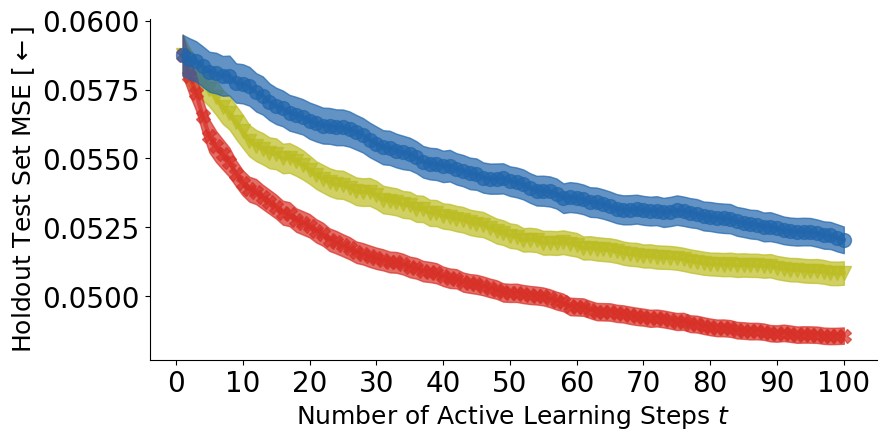

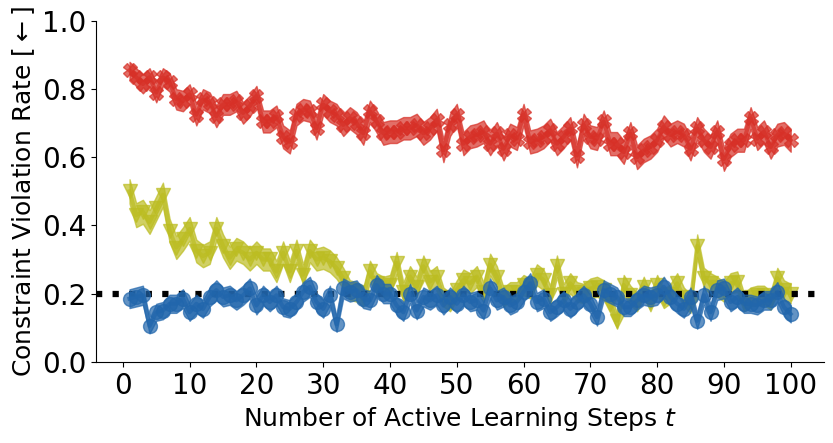

In [36]:


CB_color_cycle = ['#ff7f00', '#4daf4a', '#377eb8',
                  '#e41a1c', '#984ea3', '#f781bf',  
                  '#999999', '#dede00', '#a65628']

prob_bound_inf_str = '1.0' ## {prob_bound_inf_str = '0.0' : Bounded query function (Appendix C), prob_bound_inf_str = '1.0' : Unbounded query function (Figure 3 main paper)}
pca_bias_str_small = '3.0'
pca_bias_str_big = '3.0'

plt.rc("axes.spines", top=False, right=False)
# avoid Type 3 fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig_h_dim = 4
risk_control = 'Y'

pc_alpha = 0.5
pc_alphas_dict = {'airfoil' : 0.2, 'communities' : 0.2, 'meps' : 0.2, 'blog' : 0.2, 'robot_arm' : 0.2}

# for i_data, dataset in enumerate(['airfoil', 'communities', 'meps', 'blog']):
for i_data, dataset in enumerate(['robot_arm']): #, 'communities', 'meps', 'blog'
# for i_data, dataset in enumerate(['airfoil', 'communities']):


# for i_data, dataset in enumerate(['airfoil', 'meps', 'blog']): #, 'communities', 'meps', 'blog'


    if (dataset == 'airfoil'):
        data_no_rc = pd.read_csv('./results/2026-01-20_ALExpts_airfoil_GP_nInitial80_steps100_nseed200_lmbda10.0_wDepths1_propTrainInit0.8_addTrainProb0.5_noise0.05_pcaExpSampling3.0_aciStepSize0.005_probBoundInf1.0_rcN_aciRCN_PCalpha0.2_cVSinitY.csv')
        data_rc = pd.read_csv('./results/2026-01-20_ALExpts_airfoil_GP_nInitial80_steps100_nseed200_lmbda10.0_wDepths1_propTrainInit0.8_addTrainProb0.5_noise0.05_pcaExpSampling3.0_aciStepSize0.5_probBoundInf1.0_rcY_aciRCN_PCalpha0.2_cVSinitY.csv')
        data_aci = pd.read_csv('./results/2026-01-20_ALExpts_airfoil_GP_nInitial80_steps100_nseed200_lmbda10.0_wDepths1_propTrainInit0.8_addTrainProb0.5_noise0.05_pcaExpSampling3.0_aciStepSize0.5_probBoundInf1.0_rcY_aciRCY_PCalpha0.2_cVSinitY.csv')

    elif (dataset == 'communities'):

        data_no_rc = pd.read_csv('./results/2026-01-19_ALExpts_communities_GP_nInitial80_steps70_nseed200_lmbda10.0_wDepths1_propTrainInit0.8_addTrainProb0.5_noise0.05_pcaExpSampling8.0_aciStepSize0.005_probBoundInf1.0_rcN_aciRCN_PCalpha0.2_cVSinitY.csv')
        data_rc = pd.read_csv('./results/2026-01-20_ALExpts_communities_GP_nInitial80_steps100_nseed200_lmbda10.0_wDepths1_propTrainInit0.8_addTrainProb0.5_noise0.05_pcaExpSampling8.0_aciStepSize0.005_probBoundInf1.0_rcY_aciRCN_PCalpha0.2_cVSinitY.csv')
        data_aci = pd.read_csv('./results/2026-01-20_ALExpts_communities_GP_nInitial80_steps100_nseed200_lmbda10.0_wDepths1_propTrainInit0.8_addTrainProb0.5_noise0.05_pcaExpSampling8.0_aciStepSize0.5_probBoundInf1.0_rcY_aciRCY_PCalpha0.2_cVSinitY.csv')

    elif (dataset == 'meps'):

        data_no_rc = pd.read_csv('./results/2026-01-20_ALExpts_meps_GP_nInitial80_steps100_nseed10_lmbda10.0_wDepths1_propTrainInit0.8_addTrainProb0.5_noise0.05_pcaExpSampling8.0_aciStepSize0.005_probBoundInf1.0_rcN_aciRCN_PCalpha0.2_cVSinitY.csv')
        data_rc = pd.read_csv('./results/2026-01-20_ALExpts_meps_GP_nInitial80_steps100_nseed10_lmbda10.0_wDepths1_propTrainInit0.8_addTrainProb0.5_noise0.05_pcaExpSampling8.0_aciStepSize0.005_probBoundInf1.0_rcY_aciRCN_PCalpha0.2_cVSinitY.csv')
        data_aci = pd.read_csv('./results/2026-01-20_ALExpts_meps_GP_nInitial80_steps100_nseed10_lmbda10.0_wDepths1_propTrainInit0.8_addTrainProb0.5_noise0.05_pcaExpSampling8.0_aciStepSize0.5_probBoundInf1.0_rcY_aciRCY_PCalpha0.2_cVSinitY.csv')
        
    elif (dataset == 'blog'):

        data = pd.read_csv('./results/2026-01-19_ALExpts_communities_GP_nInitial80_steps70_nseed1_lmbda10.0_wDepths1_propTrainInit0.8_addTrainProb0.5_noise0.05_pcaExpSampling8.0_aciStepSize0.005_probBoundInf1.0_rcN_aciRCN_PCalpha0.2_cVSinitY.csv')

    elif (dataset == 'robot_arm'):
        data_no_rc = pd.read_csv('./results/2026-01-20_ALExpts_robot_arm_GP_nInitial80_steps100_nseed200_lmbda10.0_wDepths1_propTrainInit0.8_addTrainProb0.5_noise0.05_pcaExpSampling8.0_aciStepSize0.5_probBoundInf1.0_rcN_aciRCN_PCalpha0.2_cVSinitY.csv')
        data_rc = pd.read_csv('./results/2026-01-20_ALExpts_robot_arm_GP_nInitial80_steps100_nseed200_lmbda10.0_wDepths1_propTrainInit0.8_addTrainProb0.5_noise0.05_pcaExpSampling8.0_aciStepSize0.5_probBoundInf1.0_rcY_aciRCN_PCalpha0.2_cVSinitY.csv')
        data_aci = pd.read_csv('./results/2026-01-20_ALExpts_robot_arm_GP_nInitial80_steps100_nseed200_lmbda10.0_wDepths1_propTrainInit0.8_addTrainProb0.5_noise0.05_pcaExpSampling8.0_aciStepSize0.5_probBoundInf1.0_rcY_aciRCY_PCalpha0.2_cVSinitY.csv')


    data_dict = {'no_rc' : data_no_rc, 'rc' : data_rc, 'aci' : data_aci}
    data_list = [data_no_rc, data_rc, data_aci]
    
    step_adjustments = [1]
    wsplit_methods = ['wsplit_' + str(i) for i in step_adjustments]
    
    method_names = np.concatenate([['split'], wsplit_methods, ['aci', 'wsplit_mixture']]) # 'wsplit_2', 'wsplit_4', 'wsplit_5'
    method_names_citations = ['Exchangeable Split CP (Papadopoulos 2008)', '1-step FCS Split CP (Tibshirani et al., 2019 & Fannjiang et al., 2022)', \
                               '2-step FCS Split CP (Prinster et al., 2024)','3-step FCS Split CP (Prinster et al., 2024)', 'ACI (Gibbs & Candes, 2021)', 'MixtureWeights (proposed)'] #'2-step FCS Split CP (proposed)','4-step FCS Split CP (proposed)', '5-step FCS Split CP (proposed)'

    # data_all = data

    # flur_color = 'red'
    # muh_name = 'NN'
    # ntrain = 192 ## 96, 192 ## 
    # K_str = '16'
    # metric = 'coverage'
    n_seeds = min([len(set(data['seed'])) for data in data_list])
    print(n_seeds)
    n_test = 1
    # lmbdas = [0, 1, 2, 3]
    
    wid_q = 0.25
    wid_e_color = 'gray'
    plot_legend = True
    n_steps = 100

    markersize=10
    linewidth=3
    capsize=3
    elinewidth=2
    
    transparency=0.7
    linestyle_wid='--'
    linestyle_fit='-.'
    y_ax_label_size=18
    x_ax_label_size=18

    tick_sizes=20
    suptitle_size=30

    BLUE = '#2166ac'           # β̂ vertical line
    TEAL = '#5ab4ac'           # Calibration data (complements blue/red)
    RED = '#d73027' 

    colors_dict = {'no_rc' : RED, 'rc' : BLUE, 'aci' : 'C8'}
    markers_dict = {'no_rc' : 'X', 'rc' : 'o', 'aci' : 'v'}

    ## Feasible set annotations
    feasible_no_rc = data_dict['no_rc'][data_dict['no_rc']['method']=='wsplit_mixture'].groupby(['step'])['Feasible'].mean()
    feasible_no_rc_stderr = np.array(data_dict['no_rc'][data_dict['no_rc']['method']=='wsplit_mixture'][['Feasible', 'step']].groupby(['step']).std() / np.sqrt(n_seeds)).T[0]

    feasible_rc = data_dict['rc'][data_dict['rc']['method']=='wsplit_mixture'].groupby(['step'])['Feasible'].mean()
    feasible_rc_stderr = np.array(data_dict['rc'][data_dict['rc']['method']=='wsplit_mixture'][['Feasible', 'step']].groupby(['step']).std() / np.sqrt(n_seeds)).T[0]

    feasible_aci = data_dict['aci'][data_dict['aci']['method']=='wsplit_mixture'].groupby(['step'])['Feasible'].mean()
    feasible_aci_stderr = np.array(data_dict['aci'][data_dict['aci']['method']=='wsplit_mixture'][['Feasible', 'step']].groupby(['step']).std() / np.sqrt(n_seeds)).T[0]

    feasible_dict = {'no_rc' : feasible_no_rc, 'rc' : feasible_rc, 'aci' : feasible_aci}
    feasible_stderr_dict = {'no_rc' : feasible_no_rc_stderr, 'rc' : feasible_rc_stderr, 'aci' : feasible_aci_stderr}


    ## Compute MSE
    MSE_no_rc = data_dict['no_rc'][data_dict['no_rc']['method']=='split'].groupby(['step'])['MSE'].mean()
    MSE_no_rc_stderr = np.array(data_dict['no_rc'][data_dict['no_rc']['method']=='split'][['MSE', 'step']].groupby(['step']).std() / np.sqrt(n_seeds)).T[0]

    MSE_rc = data_dict['rc'][data_dict['rc']['method']=='split'].groupby(['step'])['MSE'].mean()
    MSE_rc_stderr = np.array(data_dict['rc'][data_dict['rc']['method']=='split'][['MSE', 'step']].groupby(['step']).std() / np.sqrt(n_seeds)).T[0]

    MSE_aci = data_dict['aci'][data_dict['aci']['method']=='split'].groupby(['step'])['MSE'].mean()
    MSE_aci_stderr = np.array(data_dict['aci'][data_dict['aci']['method']=='split'][['MSE', 'step']].groupby(['step']).std() / np.sqrt(n_seeds)).T[0]

    MSE_dict = {'no_rc' : MSE_no_rc, 'rc' : MSE_rc, 'aci' : MSE_aci}
    MSE_stderr_dict = {'no_rc' : MSE_no_rc_stderr, 'rc' : MSE_rc_stderr, 'aci' : MSE_aci_stderr}

    methods = ['aci', 'no_rc', 'rc']
    method_names_dict = {'no_rc' : 'Uncontrolled', 'rc' : 'Conformal Policy Control (proposed)', 'aci' : 'Conformal Controller (Lekeufack, et al. 2024)'}
    
    
    ## Plot MSE
    fig3, ax3 = plt.subplots(figsize=(8, fig_h_dim))
    fig3.tight_layout()

    ## 
    for m_i, method in enumerate(methods):
        ax3.fill_between(range(1, n_steps+1), MSE_dict[method][0:n_steps]-MSE_stderr_dict[method][0:n_steps], MSE_dict[method][0:n_steps]+MSE_stderr_dict[method][0:n_steps], alpha =transparency, color=colors_dict[method], zorder=m_i)
        ax3.plot(range(1, n_steps+1), MSE_dict[method][0:n_steps], marker=markers_dict[method], label = method_names_dict[method], linewidth=linewidth, alpha =transparency, markersize=markersize, color=colors_dict[method], zorder=m_i)

    
    # ax3.errorbar(range(1, n_steps+1), split_MSE[0:n_steps], marker='s', yerr = split_MSE_stderr[0:n_steps], ecolor = CB_color_cycle[0], label = 'split', linewidth=linewidth, alpha =transparency, markersize=markersize, color=CB_color_cycle[0], capsize=capsize,elinewidth=elinewidth)
    # ax3.errorbar(range(1, n_steps+1), split_MSE[0:n_steps], marker='s', yerr = split_MSE_stderr[0:n_steps], ecolor = CB_color_cycle[0], label = 'split', linewidth=linewidth, alpha =transparency, markersize=markersize, color=CB_color_cycle[0], capsize=capsize,elinewidth=elinewidth)
    # ax3.errorbar(range(1, n_steps+1), split_MSE[0:n_steps], marker='s', yerr = split_MSE_stderr[0:n_steps], ecolor = CB_color_cycle[0], label = 'split', linewidth=linewidth, alpha =transparency, markersize=markersize, color=CB_color_cycle[0], capsize=capsize,elinewidth=elinewidth)

    ax3.set_ylabel(r'Holdout Test Set MSE [$\leftarrow$]', fontsize=y_ax_label_size)
    ax3.set_xlabel('Number of Active Learning Steps $t$', fontsize=x_ax_label_size)
    ax3.tick_params(axis='both', labelsize=tick_sizes)
    ax3.set_xticks(np.arange(0, n_steps+1, 10.0))
    # if (dataset == 'airfoil'):
    #     ax3.set_yticks(np.arange(32, 37, 1))
    # ax3.grid()
    # ax3.set_ylim([32,36])
    
    if (prob_bound_inf_str != '1.0'):
        fig3.savefig(f'./results_figures/SplitCPActiveLearning_{dataset}_MSE.pdf',bbox_inches='tight', dpi=300)
    else:
        fig3.savefig(f'./results_figures/SplitCPActiveLearning_{dataset}_MSE.pdf',bbox_inches='tight', dpi=300)
        


    ## Plot Feasibility
    fig7, ax7 = plt.subplots(figsize=(8, fig_h_dim))
    fig7.tight_layout()
    ax7.axhline(y = pc_alphas_dict[dataset], linestyle = ':', color = 'black', linewidth=1.5*linewidth, label='Target Risk Upper Bound')

    # feasible = data[data['method']=='wsplit_mixture'].groupby(['step'])['Feasible'].mean()
    # feasible_stderr = np.array(data[data['method']=='wsplit_mixture'][['Feasible', 'step']].groupby(['step']).std() / np.sqrt(n_seeds)).T[0]

    # ## Plotting mean coverage
    # ax7.errorbar(range(1, n_steps+1), feasible[0:n_steps], marker='s', yerr = feasible_stderr[0:n_steps], ecolor = 'black', label = 'Feasible indicator', linewidth=linewidth, alpha =transparency, markersize=markersize, color='black', capsize=capsize,elinewidth=elinewidth)
    for m_i, method in enumerate(methods):
        ax7.fill_between(range(1, n_steps+1), 1-feasible_dict[method][0:n_steps]-feasible_stderr_dict[method][0:n_steps], 1-feasible_dict[method][0:n_steps]+feasible_stderr_dict[method][0:n_steps],  alpha =transparency, color=colors_dict[method], zorder=m_i)
        ax7.plot(range(1, n_steps+1), 1-feasible_dict[method][0:n_steps], marker=markers_dict[method], label = method_names_dict[method], linewidth=linewidth, alpha =transparency, markersize=markersize, color=colors_dict[method], zorder=m_i)

    

    # handles, labels = ax3.get_legend_handles_labels()


    ax7.set_ylabel(r'Constraint Violation Rate [$\leftarrow$]', fontsize=y_ax_label_size)
    ax7.set_xlabel('Number of Active Learning Steps $t$', fontsize=x_ax_label_size)
    ax7.tick_params(axis='both', labelsize=tick_sizes)
    ax7.set_xticks(np.arange(0, n_steps+1, 10.0))
    ax7.set_ylim([0,1])
    # ax7.legend(fontsize=20)



    
    fig7.savefig(f'./results_figures/SplitCPActiveLearning_{dataset}_infeasiblity.pdf',bbox_inches='tight', dpi=300)
    
    
    handles, labels = ax7.get_legend_handles_labels()
    leg = ax7.legend(handles, labels, loc=[-0.25, 1.3], ncols=8, fontsize=14, reverse=True)
    leg.set_in_layout(False)
    legend_extent = leg.get_tightbbox(fig7.canvas.get_renderer()).transformed(fig7.dpi_scale_trans.inverted())
    fig7.savefig(f'legend_ActiveLearningExpts.pdf', bbox_inches=legend_extent, dpi=300)

    

In [36]:
import sys
m = sys.float_info.min

M = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
M[:,[0, 2]]

array([[1, 3],
       [4, 6],
       [7, 9]])

In [32]:
a = list(range(1000))
a[::-100]



[999, 899, 799, 699, 599, 499, 399, 299, 199, 99]

In [9]:

def get_num_safe_actions(cal_infeasible_indicators, cal_lik_numerator, cal_lik_denominator, prop_lik_numerator, prop_lik_denominator, n_target):
    
    ## Unnormalized cal weights
    w_cal = cal_lik_numerator / cal_lik_denominator
    sum_w_cal = np.sum(w_cal)

    ## Unnormalized estimated prop weight
    w_test = np.mean(prop_lik_numerator / prop_lik_denominator)

    for n in range(n_target + 1)[::-1]:
        w_test_curr = n * w_test

        sum_w_cal_test = sum_w_cal + w_test_curr

        w_cal_normalized = w_cal / sum_w_cal_test
        w_test_curr_normalized = w_test_curr / sum_w_cal_test

        if (np.sum(w_cal_normalized[cal_infeasible_indicators]) + w_test_curr_normalized <= cfg.conformal_policy_control.alpha):
            return n



array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0])

In [3]:
a = [1, 2, 3, 4]
a[:-1]

[1, 2, 3]

In [3]:
# import numpy as np

# L = [[1, 2, 3], [4, 5, 6]]
# M = np.array(L)
# np.array(M)
L = [1, 2, 3]
# L[-1] = 4
L[:]

[1, 2, 3]

# ACI step size ablation study

In [82]:


CB_color_cycle = ['#ff7f00', '#4daf4a', '#377eb8',
                  '#e41a1c', '#984ea3', '#f781bf',  
                  '#999999', '#dede00', '#a65628']

prob_bound_inf_str = '0.0' ## {prob_bound_inf_str = '0.0' : Bounded query function (Appendix C), prob_bound_inf_str = '1.0' : Unbounded query function (Figure 3 main paper)}
pca_bias_str_small = '3.0'
pca_bias_str_big = '3.0'

plt.rc("axes.spines", top=False, right=False)
# avoid Type 3 fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig_h_dim = 5

for i_h, hyperparam in enumerate([ 0.005,  0.025, 0.05]):

    for i_data, dataset in enumerate(['airfoil']):
        print(dataset)

        if (dataset == 'airfoil'):
            # data = pd.read_csv('./results/2024-03-28_ALExpts_v7_airfoil_GP_itrain80_steps100_nseed1000_iseed0_tilt10.0_wAdjs123_PIs_propTraini0.8_addTrainProb0.5_replaceTrue_noise0.05_BySeed_pcaExpSampling' + pca_bias_str_small + '_GPRnoise0.05_sigDotProd0.05_aciStepSize0.005_beta' + prob_bound_inf_str + '_funcB.csv')
            data = pd.read_csv('/home/drewprinster/cp-ai-agents_20240201/results/2024-03-28_ALExpts_v7_airfoil_GP_itrain80_steps25_nseed500_iseed0_tilt10.0_wAdjs123_PIs_propTraini0.8_addTrainProb0.5_replaceTrue_noise0.05_BySeed_pcaExpSampling3.0_GPRnoise0.05_sigDotProd0.05_aciStepSize' + str(hyperparam) + '_beta1.0_funcB.csv')

        elif (dataset == 'communities'):
            data = pd.read_csv('/home/drewprinster/cp-ai-agents_20240201/results/2024-03-28_ALExpts_v7_communities_GP_itrain80_steps100_nseed1000_iseed0_tilt10.0_wAdjs123_PIs_propTraini0.8_addTrainProb0.5_replaceTrue_noise0.05_BySeed_pcaExpSampling' + pca_bias_str_small + '_GPRnoise0.05_sigDotProd0.05_aciStepSize0.005_beta' + prob_bound_inf_str + '_funcB.csv')

        elif (dataset == 'meps'):
            data = pd.read_csv('/home/drewprinster/cp-ai-agents_20240201/results/2024-03-28_ALExpts_v7_meps_GP_itrain80_steps100_nseed1000_iseed0_tilt10.0_wAdjs123_PIs_propTraini0.8_addTrainProb0.5_replaceTrue_noise0.05_BySeed_pcaExpSampling' + pca_bias_str_big + '_GPRnoise0.05_sigDotProd0.05_aciStepSize0.005_beta' + prob_bound_inf_str + '_funcB.csv')

        elif (dataset == 'blog'):
            data = pd.read_csv('/home/drewprinster/cp-ai-agents_20240201/results/2024-03-28_ALExpts_v7_blog_GP_itrain80_steps100_nseed1000_iseed0_tilt10.0_wAdjs123_PIs_propTraini0.8_addTrainProb0.5_replaceTrue_noise0.05_BySeed_pcaExpSampling' + pca_bias_str_big + '_GPRnoise0.05_sigDotProd0.05_aciStepSize0.005_beta' + prob_bound_inf_str + '_funcB.csv')

        data = data[data['seed']<350]


        step_adjustments = [1, 3]
        wsplit_methods = ['wsplit_' + str(i) for i in step_adjustments]

        method_names = np.concatenate([['split'], wsplit_methods, ['aci']]) # 'wsplit_2', 'wsplit_4', 'wsplit_5'
        method_names_citations = ['Exchangeable Split CP (Papadopoulos 2008)', '1-step FCS Split CP (Tibshirani et al., 2019 & Fannjiang et al., 2022)', \
                                   '2-step FCS Split CP (proposed)','3-step FCS Split CP (proposed)', 'ACI (Gibbs & Candes, 2021)'] #'2-step FCS Split CP (proposed)','4-step FCS Split CP (proposed)', '5-step FCS Split CP (proposed)'


        data_all = data

        print(max(data['seed']))




        # flur_color = 'red'
        # muh_name = 'NN'
        # ntrain = 192 ## 96, 192 ## 
        # K_str = '16'
        # metric = 'coverage'
        n_seeds = len(set(data['seed']))
        n_test = 1
        # lmbdas = [0, 1, 2, 3]


        wid_q = 0.25
        wid_e_color = 'gray'
        plot_legend = False
        n_steps = 25

        markersize=10
        linewidth=3
        capsize=3
        elinewidth=2

        transparency=0.7
        linestyle_wid='--'
        linestyle_fit='-.'
        y_ax_label_size=25
        x_ax_label_size=25

        tick_sizes=20
        suptitle_size=30


        ## Compute mean coverage
        split_cov = data[data['method']=='split'].groupby(['step']).mean()['coverage']
        split_cov_stderr = np.array(data[data['method']=='split'][['coverage', 'step']].groupby(['step']).std() / np.sqrt(n_seeds)).T[0]

        wsplit_cov_list = []
        wsplit_cov_stderr_list = []
        for i in range(min(step_adjustments), max(step_adjustments)+1):
            wsplit_cov_list.append(data[data['method']=='wsplit_' + str(i)].groupby(['step']).mean()['coverage'])
            wsplit_cov_stderr_list.append(np.array(data[data['method']=='wsplit_' + str(i)][['coverage', 'step']].groupby(['step']).std()/ np.sqrt(n_seeds)).T[0])

        aci_cov = data[data['method']=='aci'].groupby(['step']).mean()['coverage']
        aci_cov_stderr = np.array(data[data['method']=='aci'][['coverage', 'step']].groupby(['step']).std() / np.sqrt(n_seeds)).T[0]


        ## Compute median width
        split_wid = data[data['method']=='split'].groupby(['step']).median()['width']
        split_wid_stderr_l = np.array(split_wid) - np.array(data_all[data_all['method']=='split'][['width', 'step']].groupby(['step']).quantile(wid_q)).T[0]
        split_wid_stderr_u = np.array(data_all[data_all['method']=='split'][['width', 'step']].groupby(['step']).quantile(1 - wid_q)).T[0] - np.array(split_wid)

        wsplit_wid_list = []
        wsplit_wid_stderr_l_list = []
        wsplit_wid_stderr_u_list = []
        for i in range(min(step_adjustments), max(step_adjustments)+1):

            wsplit_wid_list.append(data[data['method']=='wsplit_' + str(i)].groupby(['step']).median()['width'])
            wsplit_wid_stderr_l_curr = np.array(wsplit_wid_list[-1]) - np.array(data_all[data_all['method']=='wsplit_' + str(i)][['width', 'step']].groupby(['step']).quantile(wid_q)).T[0]
            wsplit_wid_stderr_l_curr = np.nan_to_num(wsplit_wid_stderr_l_curr, nan=0.0, neginf=0.0)
            wsplit_wid_stderr_l_list.append(wsplit_wid_stderr_l_curr) ## Aesthetic plotting adjustment, for when values are -infinite

            wsplit_wid_stderr_u_curr = np.array(data_all[data_all['method']=='wsplit_' + str(i)][['width', 'step']].groupby(['step']).quantile(1-wid_q)).T[0] - np.array(wsplit_wid_list[-1])
            wsplit_wid_stderr_u_curr = np.nan_to_num(wsplit_wid_stderr_u_curr, nan=60.0, posinf=60.0)
            wsplit_wid_stderr_u_list.append(wsplit_wid_stderr_u_curr) ## Aesthetic plotting adjustment, for when values are infinite

        aci_wid = data[data['method']=='aci'].groupby(['step']).median()['width']
        aci_wid_stderr_l = np.array(aci_wid) - np.array(data_all[data_all['method']=='aci'][['width', 'step']].groupby(['step']).quantile(wid_q)).T[0]
        aci_wid_stderr_l = np.nan_to_num(aci_wid_stderr_l, nan=0.0, neginf=0.0)
        # aci_wid_stderr_l = np.where(aci_wid_stderr_l < 0, 0, aci_wid_stderr_l)
        aci_wid_stderr_u = np.array(data_all[data_all['method']=='aci'][['width', 'step']].groupby(['step']).quantile(1 - wid_q)).T[0] - np.array(aci_wid)
        aci_wid_stderr_u = np.nan_to_num(aci_wid_stderr_u, nan=60.0, neginf=60.0)


        ## Compute MSE
        split_MSE = data[data['method']=='split'].groupby(['step']).mean()['MSE']
        split_MSE_stderr = np.array(data[data['method']=='split'][['MSE', 'step']].groupby(['step']).std() / np.sqrt(n_seeds)).T[0]

        wsplit_MSE_list = []
        wsplit_MSE_stderr_list = []
        for i in range(min(step_adjustments), max(step_adjustments)+1):
            wsplit_MSE_list.append(data[data['method']=='wsplit_' + str(i)].groupby(['step']).mean()['MSE'])
            wsplit_MSE_stderr_list.append(np.array(data[data['method']=='wsplit_' + str(i)][['MSE', 'step']].groupby(['step']).std()/ np.sqrt(n_seeds)).T[0])

        aci_MSE = data[data['method']=='aci'].groupby(['step']).mean()['MSE']
        aci_MSE_stderr = np.array(data[data['method']=='aci'][['MSE', 'step']].groupby(['step']).std() / np.sqrt(n_seeds)).T[0]


        ## Relative query function bound
        prop_B = data[data['method']=='wsplit_1'].groupby(['step']).mean()['prop_B']
        prop_B_stderr = np.array(data[data['method']=='wsplit_1'][['prop_B', 'step']].groupby(['step']).std() / np.sqrt(n_seeds)).T[0]

        ### alpha_aci and prop_B
        aci_level = 1 - data[data['method']=='aci'].groupby(['step']).mean()['alpha_aci']

        # print(np.array(data[data['method']=='aci'][['alpha_aci', 'step']].groupby(['step'])))
        aci_level_stderr = (np.array(1 - data[data['method']=='aci'][['alpha_aci', 'step']].groupby(['step']).std()) / np.sqrt(n_seeds)).T[0]





        ## Plotting



        ## Plot coverage

        fig1, ax1 = plt.subplots(figsize=(8, fig_h_dim))
        fig1.tight_layout()

        ## Plotting mean coverage
        ax1.errorbar(range(1, n_steps+1), split_cov[0:n_steps], marker='s', yerr = split_cov_stderr[0:n_steps], ecolor = CB_color_cycle[0], label = 'Exchangeable Split CP (Papadopoulos 2008)', linewidth=linewidth, alpha =transparency, markersize=markersize, color=CB_color_cycle[0], capsize=capsize,elinewidth=elinewidth)

        ax1.errorbar(range(1, n_steps+1), aci_cov[0:n_steps], marker='s', yerr = aci_cov_stderr[0:n_steps], ecolor = CB_color_cycle[6], label = 'ACI (Gibbs & Candes, 2021)', linewidth=linewidth, alpha =transparency, markersize=markersize, color=CB_color_cycle[6], capsize=capsize,elinewidth=elinewidth)


        for i in step_adjustments:
        #     print(i)
            if (i == 1):
                ax1.errorbar(range(1, n_steps+1), wsplit_cov_list[i-1][0:n_steps], marker='v', yerr = wsplit_cov_stderr_list[i-1][0:n_steps], ecolor = CB_color_cycle[i], label = method_names_citations[i], linewidth=linewidth, alpha =transparency, markersize=markersize, color=CB_color_cycle[i], capsize=capsize,elinewidth=elinewidth)
            else:
                ax1.errorbar(range(1, n_steps+1), wsplit_cov_list[i-1][0:n_steps], marker='o', yerr = wsplit_cov_stderr_list[i-1][0:n_steps], ecolor = CB_color_cycle[i], label = method_names_citations[i], linewidth=linewidth, alpha =transparency, markersize=markersize, color=CB_color_cycle[i], capsize=capsize,elinewidth=elinewidth)


        ax1.axhline(y = 0.9, linestyle = ':', color = 'black', linewidth=1.5*linewidth, label='Target coverage')

        handles, labels = ax1.get_legend_handles_labels()


        ax1.set_ylabel('Mean coverage', fontsize=y_ax_label_size)
        ax1.set_xlabel('Number of active learning steps $t$', fontsize=x_ax_label_size)
        ax1.tick_params(axis='both', labelsize=tick_sizes)
        ax1.set_xticks(np.arange(0, n_steps+1, 5.0))


        if (dataset == 'airfoil'):
            ax1.set_ylim([0.78,1.0000001])
        elif (dataset == 'communities'):
            ax1.set_ylim([0.52,1.0000001])
        elif (dataset == 'meps'):
            ax1.set_ylim([0.52,1.0000001])
        elif (dataset == 'blog'):
            ax1.set_ylim([0.64,1.0000001])

        ax1.set_yticks(np.arange(0.5, 1.0000001, 0.1))
        ax1.grid()


        if (prob_bound_inf_str != '1.0'):
            fig1.savefig('/home/drewprinster/conformal-mfcs/results_figures/AblationSplitCPActiveLearning_' + dataset + '_aciStepSize' + str(hyperparam) + '_coverage.pdf',bbox_inches='tight', dpi=200)
        else:
            fig1.savefig('/home/drewprinster/conformal-mfcs/results_figures/AblationSplitCPActiveLearning_' + dataset + '_aciStepSize' + str(hyperparam) + '_coverage.pdf',bbox_inches='tight', dpi=200)



        ## Plot width
        fig2, ax2 = plt.subplots(figsize=(8, fig_h_dim))
        fig2.tight_layout()

        ax2.errorbar(range(1, n_steps+1), split_wid[0:n_steps], marker='s', yerr = np.vstack((split_wid_stderr_l[0:n_steps], split_wid_stderr_u[0:n_steps])), ecolor = CB_color_cycle[0], label = 'split', linewidth=linewidth, alpha =transparency, markersize=markersize, color=CB_color_cycle[0], capsize=capsize,elinewidth=elinewidth)
        ax2.errorbar(range(1, n_steps+1), aci_wid[0:n_steps], marker='s', yerr = np.vstack((aci_wid_stderr_l[0:n_steps], aci_wid_stderr_u[0:n_steps])), ecolor = CB_color_cycle[6], label = 'aci', linewidth=linewidth, alpha =transparency, markersize=markersize, color=CB_color_cycle[6], capsize=capsize,elinewidth=elinewidth)


        for i in step_adjustments:
            if (i == 1):
                ax2.errorbar(range(1, n_steps+1), wsplit_wid_list[i-1][0:n_steps], marker='v', yerr = np.vstack((wsplit_wid_stderr_l_list[i-1][0:n_steps], wsplit_wid_stderr_u_list[i-1][0:n_steps])), ecolor = CB_color_cycle[i], label = method_names_citations[i], linewidth=linewidth, alpha =transparency, markersize=markersize, color=CB_color_cycle[i], capsize=capsize, elinewidth=elinewidth)
            else:
                ax2.errorbar(range(1, n_steps+1), wsplit_wid_list[i-1][0:n_steps], marker='o', yerr = np.vstack((wsplit_wid_stderr_l_list[i-1][0:n_steps], wsplit_wid_stderr_u_list[i-1][0:n_steps])), ecolor = CB_color_cycle[i], label = method_names_citations[i], linewidth=linewidth, alpha =transparency, markersize=markersize, color=CB_color_cycle[i], capsize=capsize, elinewidth=elinewidth)

        ax2.set_ylabel('Median interval width', fontsize=y_ax_label_size)
        ax2.set_xlabel('Number of active learning steps $t$', fontsize=x_ax_label_size)
        if (dataset == 'airfoil'):
            # ax2.set_title('Airfoil dataset', y=1.025, fontsize=suptitle_size)
            ax2.set_ylim([0,39])
        elif (dataset == 'communities'):
            # ax2.set_title('Communities dataset', y=1.025, fontsize=suptitle_size)
            ax2.set_ylim([0,4.5])
        elif (dataset == 'meps'):
            # ax2.set_title('MEPS dataset', y=1.025, fontsize=suptitle_size)
            ax2.set_ylim([0,15])
        elif (dataset == 'blog'):
            # ax2.set_title('Blog dataset', y=1.025, fontsize=suptitle_size)
            ax2.set_ylim([0,155])

        # ax2.axhline(y = 0.9, linestyle = ':', color = 'black', linewidth=2)
        ax2.tick_params(axis='both', labelsize=tick_sizes)
        ax2.set_xticks(np.arange(0, n_steps+1, 5.0))
        ax2.grid()

        if (prob_bound_inf_str != '1.0'):
            fig2.savefig('/home/drewprinster/conformal-mfcs/results_figures/AblationSplitCPActiveLearning_' + dataset + '_aciStepSize' + str(hyperparam) + '_width.pdf',bbox_inches='tight', dpi=200)
        else:
            fig2.savefig('/home/drewprinster/conformal-mfcs/results_figures/AblationSplitCPActiveLearning_' + dataset + '_aciStepSize' + str(hyperparam) + '_width.pdf',bbox_inches='tight', dpi=200)


        ## Plot MSE
        fig3, ax3 = plt.subplots(figsize=(8, fig_h_dim))
        fig3.tight_layout()

        ax3.errorbar(range(1, n_steps+1), split_MSE[0:n_steps], marker='s', yerr = split_MSE_stderr[0:n_steps], ecolor = CB_color_cycle[0], label = 'split', linewidth=linewidth, alpha =transparency, markersize=markersize, color=CB_color_cycle[0], capsize=capsize,elinewidth=elinewidth)
        ax3.errorbar(range(1, n_steps+1), aci_MSE[0:n_steps], marker='s', yerr = aci_MSE_stderr[0:n_steps], ecolor = CB_color_cycle[6], label = 'aci', linewidth=linewidth, alpha =transparency, markersize=markersize, color=CB_color_cycle[6], capsize=capsize,elinewidth=elinewidth)

        for i in step_adjustments:
            if (i == 1):
                ax3.errorbar(range(1, n_steps+1), wsplit_MSE_list[i-1][0:n_steps], marker='v', yerr = wsplit_MSE_stderr_list[i-1][0:n_steps], ecolor = CB_color_cycle[i], label = method_names_citations[i], linewidth=linewidth, alpha =transparency, markersize=markersize, color=CB_color_cycle[i], capsize=capsize,elinewidth=elinewidth)
            else:
                ax3.errorbar(range(1, n_steps+1), wsplit_MSE_list[i-1][0:n_steps], marker='o', yerr = wsplit_MSE_stderr_list[i-1][0:n_steps], ecolor = CB_color_cycle[i], label = method_names_citations[i], linewidth=linewidth, alpha =transparency, markersize=markersize, color=CB_color_cycle[i], capsize=capsize,elinewidth=elinewidth)

        ax3.set_ylabel('Holdout test set MSE', fontsize=y_ax_label_size)
        ax3.set_xlabel('Number of active learning steps $t$', fontsize=x_ax_label_size)
        ax3.tick_params(axis='both', labelsize=tick_sizes)
        ax3.set_xticks(np.arange(0, n_steps+1, 5.0))
        if (dataset == 'airfoil'):
            ax3.set_yticks(np.arange(33, 37, 1))
        ax3.grid()

        if (prob_bound_inf_str != '1.0'):
            fig3.savefig('/home/drewprinster/conformal-mfcs/results_figures/AblationSplitCPActiveLearning_' + dataset + '_aciStepSize' + str(hyperparam) + '_MSE.pdf',bbox_inches='tight', dpi=200)
        else:
            fig3.savefig('/home/drewprinster/conformal-mfcs/results_figures/AblationSplitCPActiveLearning_' + dataset + '_aciStepSize' + str(hyperparam) + '_MSE.pdf',bbox_inches='tight', dpi=200)



        ## Plot relative bound
        fig4, ax4 = plt.subplots(figsize=(8, fig_h_dim))
        fig4.tight_layout()

        # ### Prop B
        # if (prob_bound_inf_str != '1.0'):

        # ax4.errorbar(range(1, n_steps+1), prop_B[0:n_steps], marker='s', yerr = prop_B_stderr[0:n_steps], ecolor = 'black', label = 'B / max(w_{n+t}(x))', linewidth=linewidth, alpha =transparency, markersize=markersize, color='black', capsize=capsize,elinewidth=elinewidth)
        # ax4.set_ylabel('Relative magnitude of B', fontsize=y_ax_label_size)
        # ax4.set_xlabel('Number of active learning steps $t$', fontsize=x_ax_label_size)
        # ax4.tick_params(axis='both', labelsize=tick_sizes)
        # ax4.set_xticks(np.arange(0, n_steps+1, 5.0))
        # ax4.set_title('Relative magnitude of \n query function bound B', fontsize=y_ax_label_size+4)
        # ax4.set_ylim(top=1.0)
        ax4.errorbar(range(1, n_steps+1), aci_level[0:n_steps], marker='s', yerr = aci_level_stderr[0:n_steps], ecolor = CB_color_cycle[6], label = 'ACI quantile level $1- ' + chr(945) + '_{aci}$', linewidth=linewidth, alpha =transparency, markersize=markersize, color=CB_color_cycle[6], capsize=capsize,elinewidth=elinewidth)
        ax4.set_ylabel('$1- ' + chr(945) + '_{aci}$', fontsize=y_ax_label_size)
        ax4.set_xlabel('Number of active learning steps $t$', fontsize=x_ax_label_size)
        ax4.tick_params(axis='both', labelsize=tick_sizes)
        ax4.set_xticks(np.arange(0, n_steps+1, 5.0))
        ax4.set_title('ACI quantile level $1- ' + chr(945) + '_{aci}$', fontsize=y_ax_label_size)
        ax4.set_ylim([0.8, 1.02])
        ax4.grid()

        fig4.savefig('/home/drewprinster/conformal-mfcs/results_figures/AblationSplitCPActiveLearning_' + dataset + '_aciStepSize' + str(hyperparam) + '_ACIlevel.pdf',bbox_inches='tight', dpi=200)

        # else:
            # fig4.savefig('/home/drewprinster/cp-ai-agents_20240201/results_figures/AblationSplitCPActiveLearning_unbounded_' + dataset + '_aciStepSize' + str(hyperparam) + '_propB.pdf',bbox_inches='tight', dpi=300)


        ## Plot legend
        fig5, ax5 = plt.subplots(figsize=(0, 0))

        ax5.set_xticks([])
        ax5.set_yticks([])

        order = list(range(0, len(method_names)+1))
        ax5.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc=[-0.15,1.3],ncol=3,fontsize=20)

        if (prob_bound_inf_str != '1.0'):
            fig5.savefig('/home/drewprinster/conformal-mfcs/results_figures/AblationSplitCPActiveLearning_legend.pdf',bbox_inches='tight', dpi=200)
        else:
            fig5.savefig('/home/drewprinster/conformal-mfcs/results_figures/AblationSplitCPActiveLearning_legend.pdf',bbox_inches='tight', dpi=200)



        ## Plot title
        fig6, ax6 = plt.subplots(figsize=(0, 0))


        ax6.set_xticks([])
        ax6.set_yticks([])


        if (prob_bound_inf_str != '1.0'):
            ax6.set_title('ACI step size = ' + str(hyperparam), y=1.025, fontsize=suptitle_size)
            fig6.savefig('/home/drewprinster/conformal-mfcs/results_figures/AblationSplitCPActiveLearning_' + dataset + '_aciStepSize' + str(hyperparam) + '_title.pdf',bbox_inches='tight', dpi=200)
        else:
            ax6.set_title('ACI step size = ' + str(hyperparam), y=1.025, fontsize=suptitle_size)
            fig6.savefig('/home/drewprinster/conformal-mfcs/results_figures/AblationSplitCPActiveLearning_' + dataset + '_aciStepSize' + str(hyperparam) + '_title.pdf',bbox_inches='tight', dpi=200)

    

airfoil


FileNotFoundError: [Errno 2] No such file or directory: '/home/drewprinster/cp-ai-agents_20240201/results/2024-03-28_ALExpts_v7_airfoil_GP_itrain80_steps25_nseed500_iseed0_tilt10.0_wAdjs123_PIs_propTraini0.8_addTrainProb0.5_replaceTrue_noise0.05_BySeed_pcaExpSampling3.0_GPRnoise0.05_sigDotProd0.05_aciStepSize0.005_beta1.0_funcB.csv'